<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#The-data" data-toc-modified-id="The-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>The data</a></span></li><li><span><a href="#Data-diagnosis-and-prep" data-toc-modified-id="Data-diagnosis-and-prep-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data diagnosis and prep</a></span><ul class="toc-item"><li><span><a href="#missing-values" data-toc-modified-id="missing-values-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>missing values</a></span><ul class="toc-item"><li><span><a href="#Checking-on-NaNs" data-toc-modified-id="Checking-on-NaNs-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Checking on NaNs</a></span></li><li><span><a href="#Checking-on-zeros" data-toc-modified-id="Checking-on-zeros-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Checking on zeros</a></span></li></ul></li></ul></li><li><span><a href="#Scrap" data-toc-modified-id="Scrap-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Scrap</a></span></li></ul></div>

In [1]:

# frequently used builtins
import os
from collections import Counter, defaultdict

# frequently used data pkgs
import numpy as np
import pandas as pd
			
# careful import of matplotlib
try:
	import matplotlib.pyplot as plt
except ModuleNotFoundError as e:  # to catch ModuleNotFoundError: No module named '_tkinter'
	import matplotlib
	matplotlib.use('agg')
	import matplotlib.pyplot as plt

# some magic stuff
%reload_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format='retina'




# The data

The data is expected to be 
- a mapping whose values index time and 
- whose values are `pandas.DataFrame` instances 
    - whose index are tickers (or groups, or whatever, but rows are the items under study) and
    - whose columns represent their features.

The package comes with some default data you can play with. To get it, make a `QuarterlyData` instance.

In [1]:
from wealth import QuarterlyData
import pandas as pd

data = QuarterlyData()
len(data)

44

Keys are (year, quarter) pairs:

In [2]:
list(data)[:3]

[(2010, 'Q1'), (2010, 'Q2'), (2010, 'Q3')]

Values are pandas.DataFrames whose indices are tickers (or groups, or whatever,
but rows are the items under study) and whose columns represent their features.

In [4]:
df = data[2010, 'Q1']
assert isinstance(df, pd.DataFrame)
list(df.index)[:4]

['AAP', 'AAPL', 'ABT', 'ACIW']

In [5]:
list(df.columns)[:4]

['EBITDA', 'Total Debt', 'Free Cash Flow', 'Gross Profit Margin']

In [6]:
df.head()

,EBITDA,Total Debt,Free Cash Flow,Gross Profit Margin,Operating Margin,Net Profit Margin,Return on Equity,Return on Assets,Free Cash Flow to Net Income,Current Ratio,...,Debt Ratio,Earnings Per Share,Basic,Earnings Per Share.1,Diluted,Sales Per Share,Equity Per Share,Free Cash Flow Per Share,Dividends Per Share,Pietroski F-Score
Ticker,,,,,,,,,,,,,,,,,,,,,
AAP,2.318550e+08,278988000,4.116780e+08,0.49753,0.09951,0.05978,0.09864,0.03417,3.76199,1.19178,...,0.08711,1.15850,1.15054,19.37990,11.74460,4.35827,0.11543,8.0,0.0,0.0
AAPL,4.934000e+09,0,7.497000e+09,0.40879,0.30128,0.21539,0.09444,0.06264,2.21936,2.54501,...,0.00000,0.13352,0.13116,0.61990,1.41380,0.29633,0.00000,7.0,0.0,0.0
ABT,2.032984e+09,17327169000,1.890403e+09,0.56678,0.19101,0.13029,0.04773,0.01880,1.88472,1.16513,...,0.32473,0.64802,0.64241,4.97369,13.47713,1.22134,0.40105,0.0,0.0,0.0
ACIW,5.586000e+06,75000000,4.039000e+06,0.64708,-0.01031,-0.02381,-0.00907,-0.00373,-1.93346,1.53265,...,0.13384,-0.02065,-0.02065,0.86724,2.27639,0.03992,0.00000,7.0,0.0,0.0
ACN,8.613060e+08,2589000,4.872030e+08,0.31038,0.12986,0.07739,0.13423,0.03651,1.09529,1.44553,...,0.00021,0.70435,0.57429,9.10125,4.44837,0.77147,0.87319,0.0,0.0,0.0


# Data diagnosis and prep

In [7]:
from wealth import QuarterlyData
import pandas as pd

data = QuarterlyData()
len(data)
df = data[2010, 'Q1']

## missing values

Are there any missing values? 

If so how are missing values indicated? Best practice in DataFrame it's with a `NaN` entry, 
but in the raw data source could come as a 0, a string ('nan', 'none', 'missing'), a special number (typically `-1` or an integer made with only `9`s 
(silly legacy of SPSS an SAS)).


### Checking on NaNs

In [9]:
assert not df.isna().any(axis=None)  # there's no NaNs or Nones in the DataFrame  (any(df.isna()) is not the right way to do this!)
assert not df.isnull().any(axis=None)  # isnull is another (equivalent?) way to detect missing values (don't know the difference)

### Checking on zeros

In [10]:
from oplot import heatmap  # pip install oplot

def heatmap_of_values(df):
    heatmap(df.values, figsize=(10, 10));
    plt.xticks(range(len(df.columns)), df.columns, rotation=90);
    plt.yticks([],[]);

/Users/Thor.Whalen/Dropbox/dev/p3/proj/o/omodel/omodel/ml/flr.py:971: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.rettaging is 'single_rettager':


The data doesn't seem to have SPSS/SAS `999` markers, but does seem to have a lot of zeros. 
Could some of these zeros be indicating missing values?

The problem is without domain knowledge it can be tricky to determine if a zero is "natural" or "unnatural". 

In [11]:
df.columns

Index(['EBITDA', 'Total Debt', 'Free Cash Flow', 'Gross Profit Margin',
       'Operating Margin', 'Net Profit Margin', 'Return on Equity',
       'Return on Assets', 'Free Cash Flow to Net Income', 'Current Ratio',
       'Liabilities to Equity Ratio', 'Debt Ratio', 'Earnings Per Share',
       ' Basic', 'Earnings Per Share.1', ' Diluted', 'Sales Per Share',
       'Equity Per Share', 'Free Cash Flow Per Share', 'Dividends Per Share',
       'Pietroski F-Score'],
      dtype='object')

Following is a heatmap of the data revealing where the zeros are.

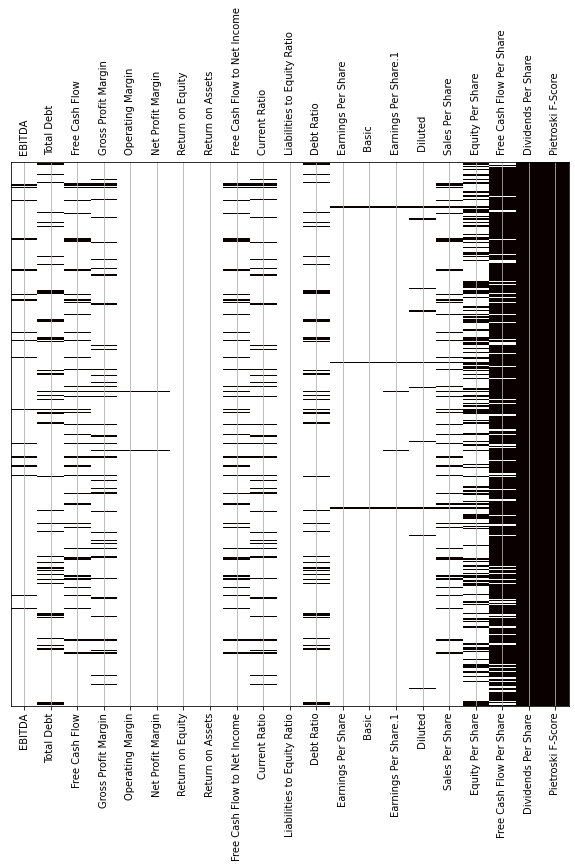

In [12]:
from oplot import heatmap

heatmap(df.values == 0, figsize=(10, 10));
plt.xticks(range(len(df.columns)), df.columns, rotation=90);
plt.yticks([],[]);

Okay, so we already see that `Dividends Per Share` and `Pietroski F-Score` are all zeros. 
This is only for the first slice -- perhaps it's some data that only appears in later years, but still may want to remove from analysis for consistency.

Are these zeros natural? Well, one thing that may add some information is whether there are negative values too.

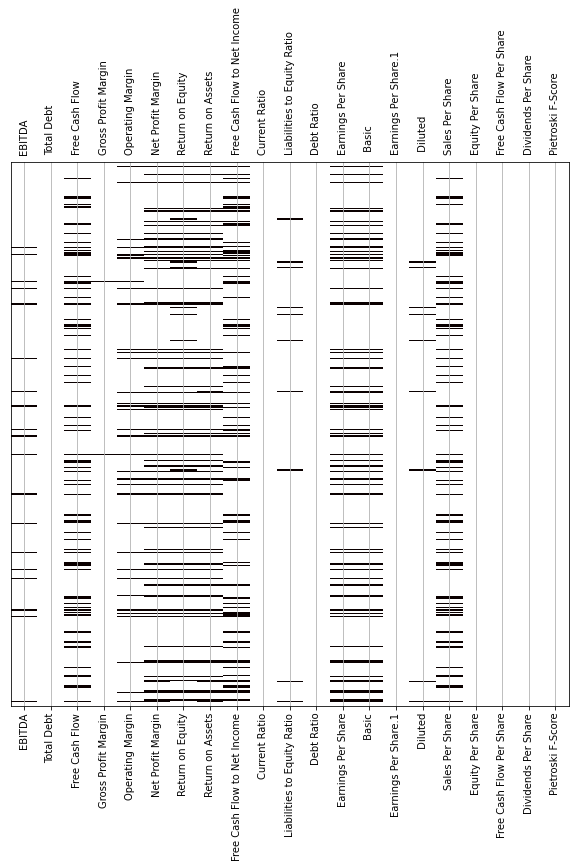

In [13]:
heatmap_of_values(df < 0)

In [107]:
print("Which columns have negative values?")
t = (df < 0).any(axis=0)
cols_that_have_negative_values = t[t].index.values
print(*(f"'{x}'" for x in cols_that_have_negative_values), sep=', ')

Which columns have negative values?
'EBITDA', 'Free Cash Flow', 'Gross Profit Margin', 'Operating Margin', 'Net Profit Margin', 'Return on Equity', 'Return on Assets', 'Free Cash Flow to Net Income', 'Liabilities to Equity Ratio', 'Earnings Per Share', ' Basic', ' Diluted', 'Sales Per Share'


Does having negative values mean a zero is natural? Well, it depends on the data. 

If the zeros have a high count next to all possible unique values, maybe the zeros aren't natural.

Text(0.5, 1.0, 'EBITDA: d.min()=-244000000.0')

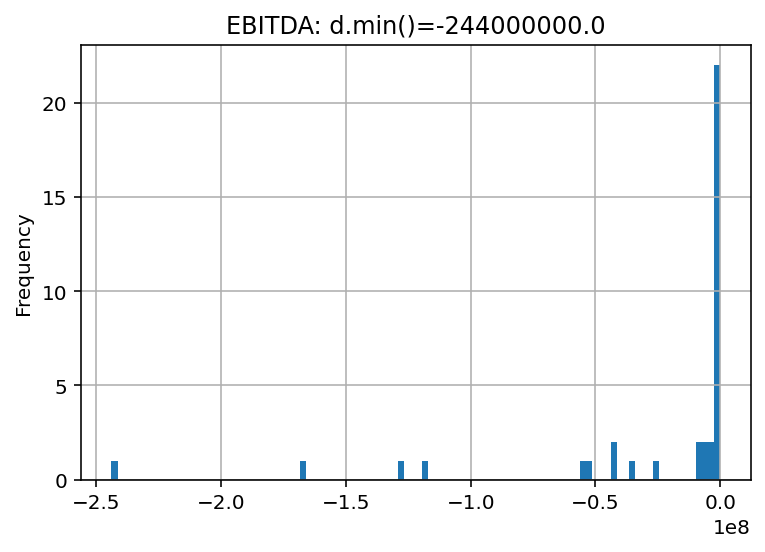

In [113]:
def hist_of_negatives(df, col, include_zeros=False, bins=100):
    col = 'EBITDA'

    d = df[col]
    if include_zeros:
        t = d[d <= 0]
    else:
        t = d[d < 0]
    t.plot(kind='hist', bins=bins)
    plt.grid(True)
    plt.title(f"{col}")
#     plt.title(f"{col}: {d.min()=}")

In [114]:
from meshed.dag import DAG

meshed.dag.DAG

In [ ]:
from oplot import ax_func_to_plot

ax_func_to_plot()

In [86]:
print("Which columns have not NOE have negative values?")

cols_that_do_not_have_negative_values = t[~t].index.values
cols_that_do_not_have_negative_values
t[~t]

Which columns have not NOE have negative values?


Total Debt                  False
Current Ratio               False
Debt Ratio                  False
Earnings Per Share.1        False
Equity Per Share            False
Free Cash Flow Per Share    False
Dividends Per Share         False
Pietroski F-Score           False
dtype: bool

In [83]:
cols_that_do_not_have_negative_values = t[~t].index.values
cols_that_do_not_have_negative_values

array(['Total Debt', 'Current Ratio', 'Debt Ratio',
       'Earnings Per Share.1', 'Equity Per Share',
       'Free Cash Flow Per Share', 'Dividends Per Share',
       'Pietroski F-Score'], dtype=object)

(array([], dtype=float64), [])

In [57]:
len(t[0]), df.columns.size

(0, 21)

<AxesSubplot:>

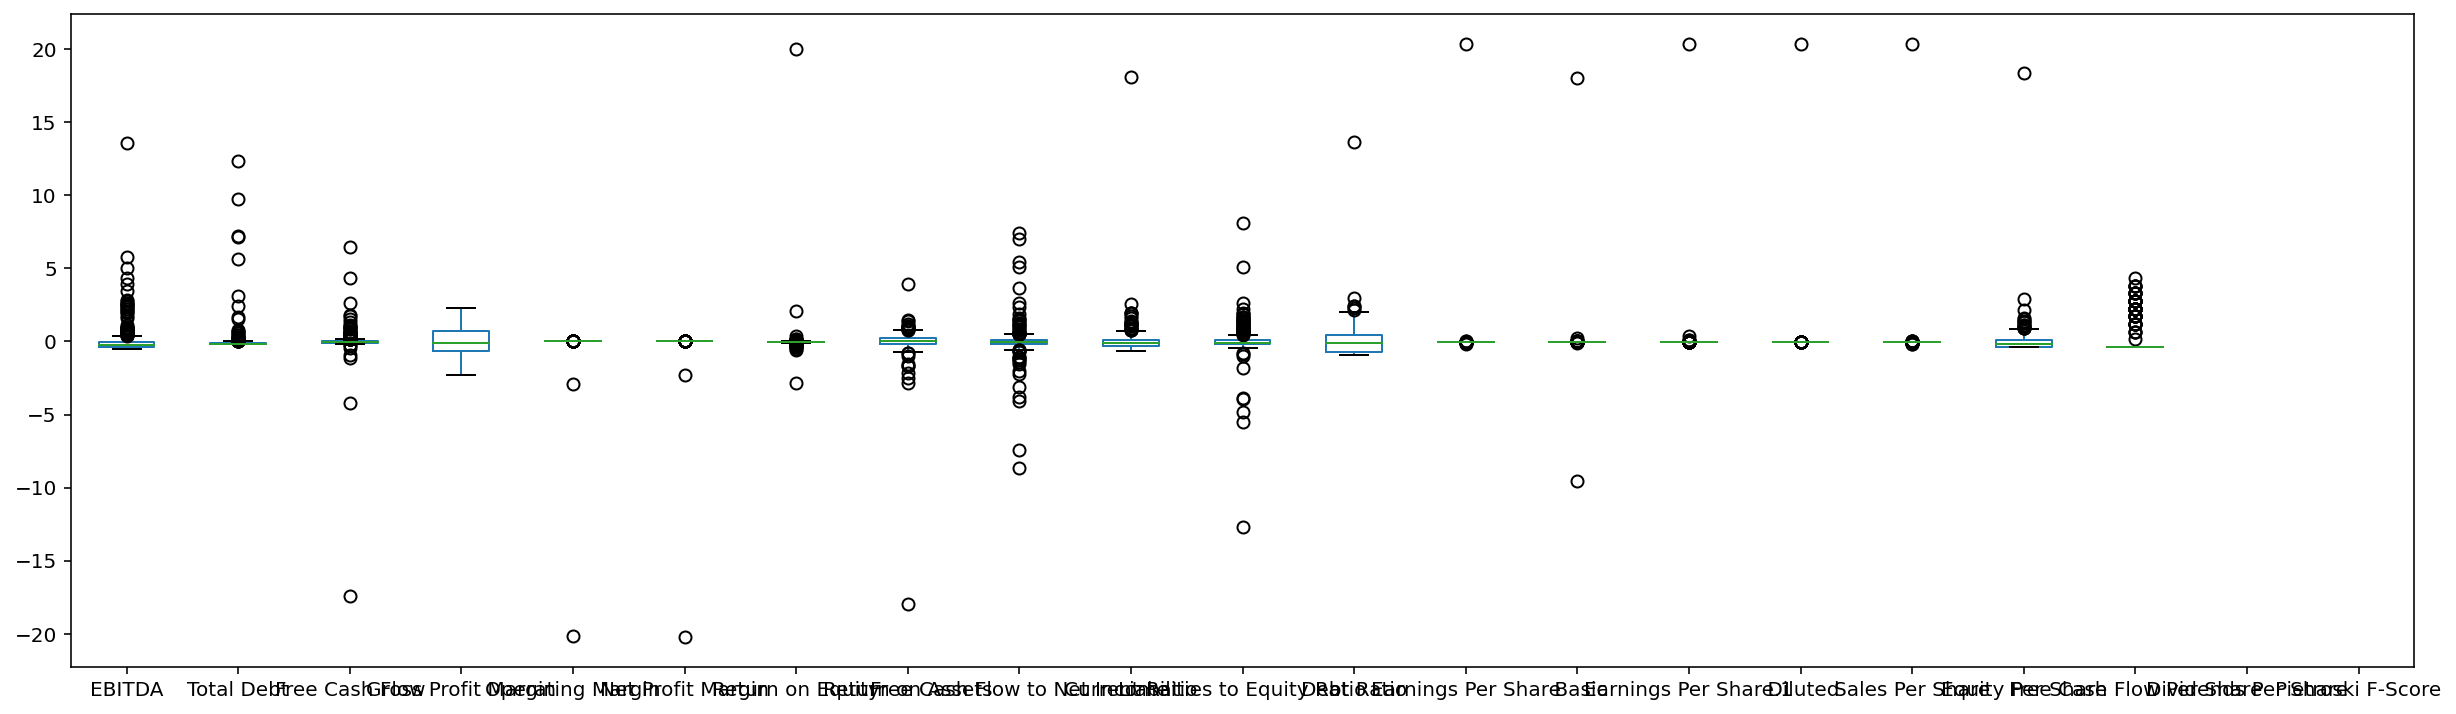

In [18]:
dd = (d - d.mean()) / d.std()
dd.plot.box(figsize=(21, 6))

<AxesSubplot:ylabel='Frequency'>

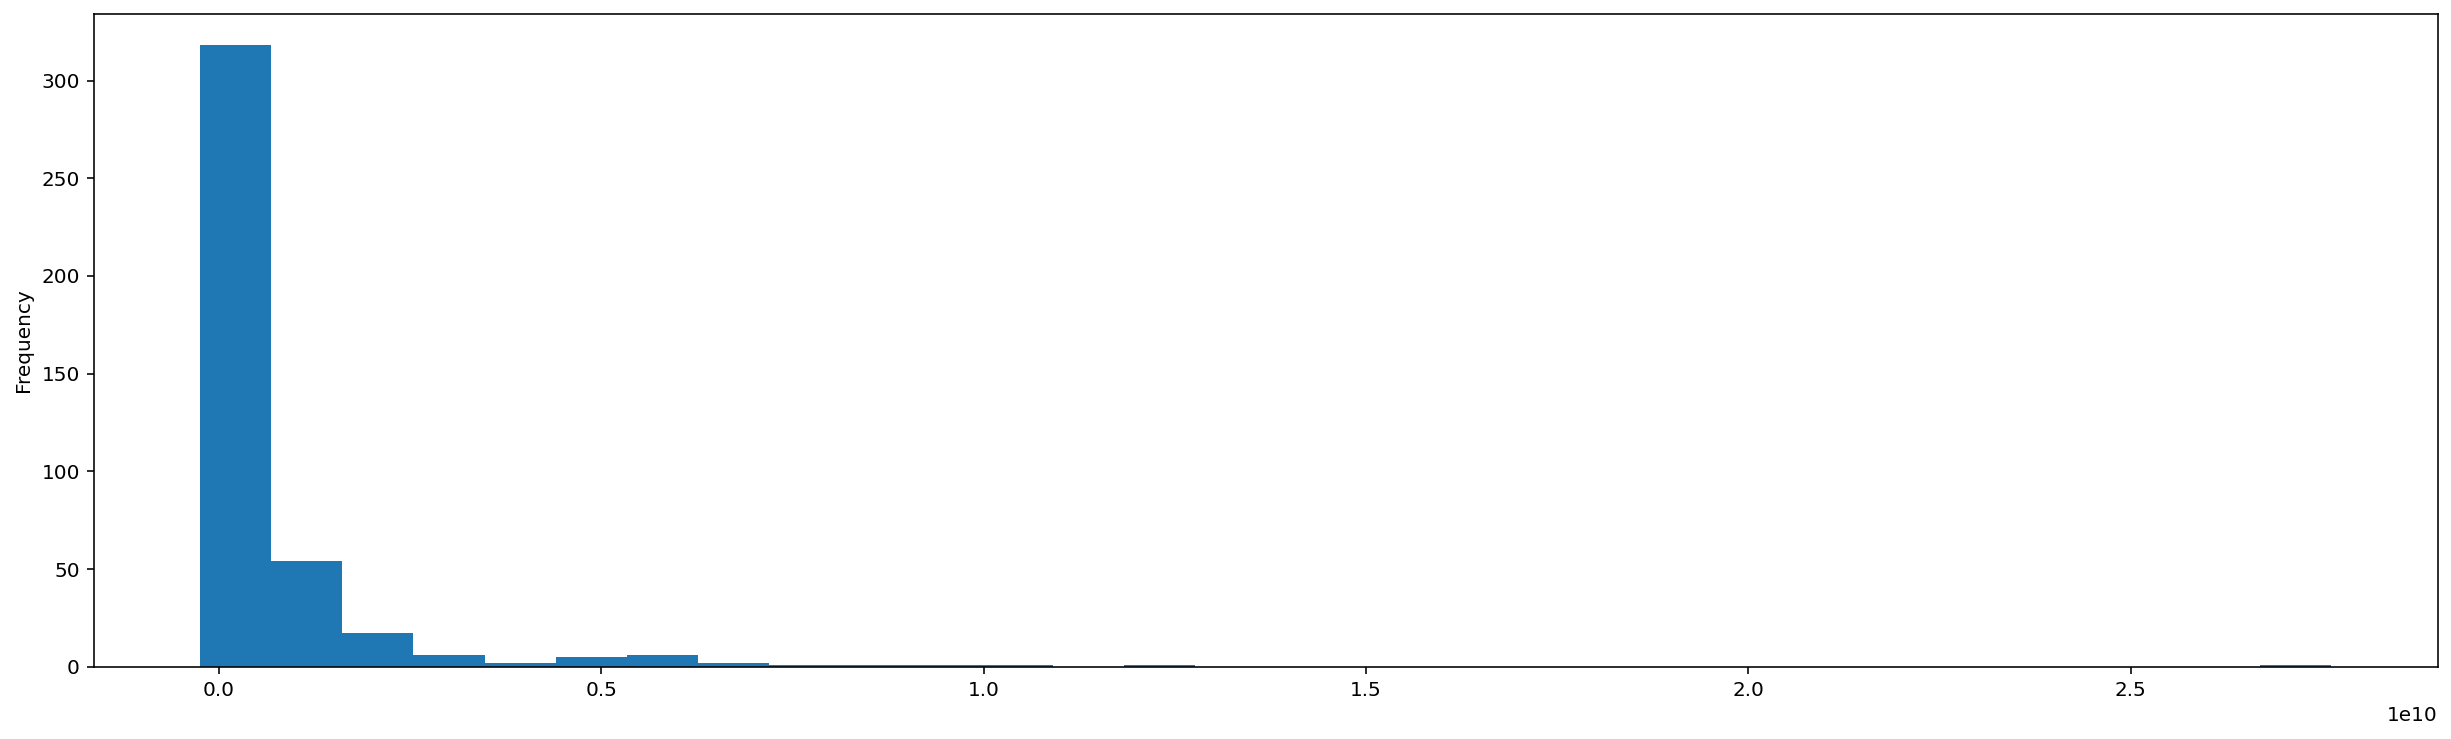

In [20]:
d['EBITDA'].plot(kind='hist', bins=30, figsize=(21, 6))

# Scrap

In [95]:
from ut.daf.get import rand as rand_df

dataframe = rand_df()
dataframe

,A,B,C
0,1,3,1
1,1,3,2
2,5,5,4
3,3,2,2
4,1,3,3
5,4,3,1
6,5,1,3
7,2,1,2
8,5,2,1


In [99]:
dataframe.to_dict(orient='records')

[{'A': 1, 'B': 3, 'C': 1},
 {'A': 1, 'B': 3, 'C': 2},
 {'A': 5, 'B': 5, 'C': 4},
 {'A': 3, 'B': 2, 'C': 2},
 {'A': 1, 'B': 3, 'C': 3},
 {'A': 4, 'B': 3, 'C': 1},
 {'A': 5, 'B': 1, 'C': 3},
 {'A': 2, 'B': 1, 'C': 2},
 {'A': 5, 'B': 2, 'C': 1}]

In [98]:
pd.DataFrame(dataframe.to_dict(orient='records'))

,A,B,C
0,1,3,1
1,1,3,2
2,5,5,4
3,3,2,2
4,1,3,3
5,4,3,1
6,5,1,3
7,2,1,2
8,5,2,1


In [103]:
from i2 import Sig

print(Sig(heatmap))

(X, y=None, col_labels=None, figsize=None, cmap=None, return_gcf=False, ax=None, xlabel_top=True, ylabel_left=True, xlabel_bottom=True, ylabel_right=True, **kwargs)
